In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 1024
PATIENCE = 100
NB_FEATURES = 2

In [3]:
input_signals = np.load('input_signals.npy')
input_labels = np.load('input_labels.npy')
input_reg_signals = np.load('input_reg_signals.npy')
input_reg_labels = np.load('input_reg_labels.npy')
count_0, count_1 = np.load('nb_classes.npy')
class_weight = np.load('class_weight.npy')
class_weight = {0: class_weight[0], 1:class_weight[1]}

INPUT_CLS_SHAPE = [-1, 1, input_signals.shape[-1], 1]
INPUT_REG_SHAPE = [-1, 1, input_reg_signals.shape[-1], 1]

print(input_signals.shape, input_labels.shape)
print(input_reg_signals.shape, input_reg_labels.shape)
print(class_weight, count_0, count_1)
print(INPUT_CLS_SHAPE, INPUT_REG_SHAPE)

(1157, 22) (1157,)
(3859, 20) (3859,)
{0: 0.7591863517060368, 1: 1.4645569620253165} 762 395
[-1, 1, 22, 1] [-1, 1, 20, 1]


In [4]:
input_signals = input_signals.reshape(INPUT_CLS_SHAPE)
input_labels = input_labels.reshape(-1, 1)
input_reg_signals = input_reg_signals.reshape(INPUT_REG_SHAPE)
input_reg_labels = input_reg_labels.reshape(-1, 1)

train_input = []
train_label = []
val_input = []
val_label = []
cur_count_0 = 0
cur_count_1 = 0
for i in range(len(input_labels)):
    if input_labels[i] == 0:
        cur_count_0 += 1
        if cur_count_0 < int(count_0 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
    else:
        cur_count_1 += 1
        if cur_count_1 < int(count_1 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
            
train_input = np.array(train_input)
train_label = np.array(train_label)
val_input = np.array(val_input)
val_label = np.array(val_label)

train_reg_input = input_reg_signals[:int(input_reg_signals.shape[0] * 0.8)]
val_reg_input = input_reg_signals[int(input_reg_signals.shape[0] * 0.8):]
train_reg_label = input_reg_labels[:int(input_reg_labels.shape[0] * 0.8)]
val_reg_label = input_reg_labels[int(input_reg_labels.shape[0] * 0.8):]

In [5]:
def shuffle(data, label):
    shuffle_index = np.arange(data.shape[0])
    np.random.shuffle(shuffle_index)
    data = data[shuffle_index]
    label = label[shuffle_index]
    return data, label

In [6]:
train_input, train_label = shuffle(train_input, train_label)
val_input, val_label = shuffle(val_input, val_label)
train_reg_input, train_reg_label = shuffle(train_reg_input, train_reg_label)
val_reg_input, val_reg_label = shuffle(val_reg_input, val_reg_label)

In [9]:
print(f'train_cls_shape:{train_input.shape}\n',
      f'val_cls_shape:{val_input.shape}\n',
      f'train_reg_shape:{train_reg_input.shape}\n',
      f'val_reg_shape:{val_reg_input.shape}\n'
     )

train_cls_shape:(923, 1, 22, 1)
 val_cls_shape:(234, 1, 22, 1)
 train_reg_shape:(3087, 1, 20, 1)
 val_reg_shape:(772, 1, 20, 1)



In [10]:
@tf.keras.utils.register_keras_serializable('JSC')
class Jaccard(tf.keras.Metric):
    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [ ]:
"""
regression_model = Anomalous_regression()
regression_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                             metrics=[tf.keras.metrics.MeanAbsoluteError(
                                 name='mean_absolute_error', dtype=None)]
                        ) 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                 )
    
history = regression_model.fit(x=train_reg_tf,
                                   validation_data=val_reg_tf,
                                   epochs=MAX_EPOCHS,
                                   shuffle=True,
                                   callbacks=[early_stopping],
                                   verbose=2
                                  )
regression_model.save('regression_model_.keras')
"""

In [11]:
train_input_signal = train_input[:,:,:-NB_FEATURES,:]
train_input_features = train_input[:,:,-NB_FEATURES:,:].reshape(-1, NB_FEATURES)
val_input_signal = val_input[:,:,:-NB_FEATURES,:]
val_input_features = val_input[:,:,-NB_FEATURES:,:].reshape(-1, NB_FEATURES)

print(f'signal_shape:{train_input_signal.shape}\n',
      f'feature_shape:{train_input_features.shape}\n',
     )

signal_shape:(923, 1, 20, 1)
 feature_shape:(923, 2)



In [12]:
signal_input = keras.Input(shape=train_input_signal.shape[1:], name="signal")
feature_input = keras.Input(shape=(NB_FEATURES,), name="features")

cls_conv_lstm = layers.ConvLSTM1D(filters=32, kernel_size=2, strides=1, padding='same', dropout=0.1)(signal_input)
cls_bidirec_lstm = layers.Bidirectional(layers.LSTM(32))(cls_conv_lstm)
cls_flatten =  layers.Flatten()(cls_bidirec_lstm)
cls_feature_dense = layers.Dense(units=2)(feature_input)
cls_concat = layers.concatenate([cls_flatten, cls_feature_dense])
cls_last_layer = layers.Dense(units=1, activation='sigmoid')(cls_concat)

cls_model = keras.Model(
    inputs=[signal_input, feature_input],
    outputs=[cls_last_layer],
    name='anomalous_detection'
)

Metal device set to: Apple M1


2024-05-09 19:58:03.224763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-09 19:58:03.224802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
cls_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3/2),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='Acc'),
                           Jaccard(name='JSC', dtype=None)]
                 )
cls_model.build(input_shape=INPUT_CLS_SHAPE[1:])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                 )

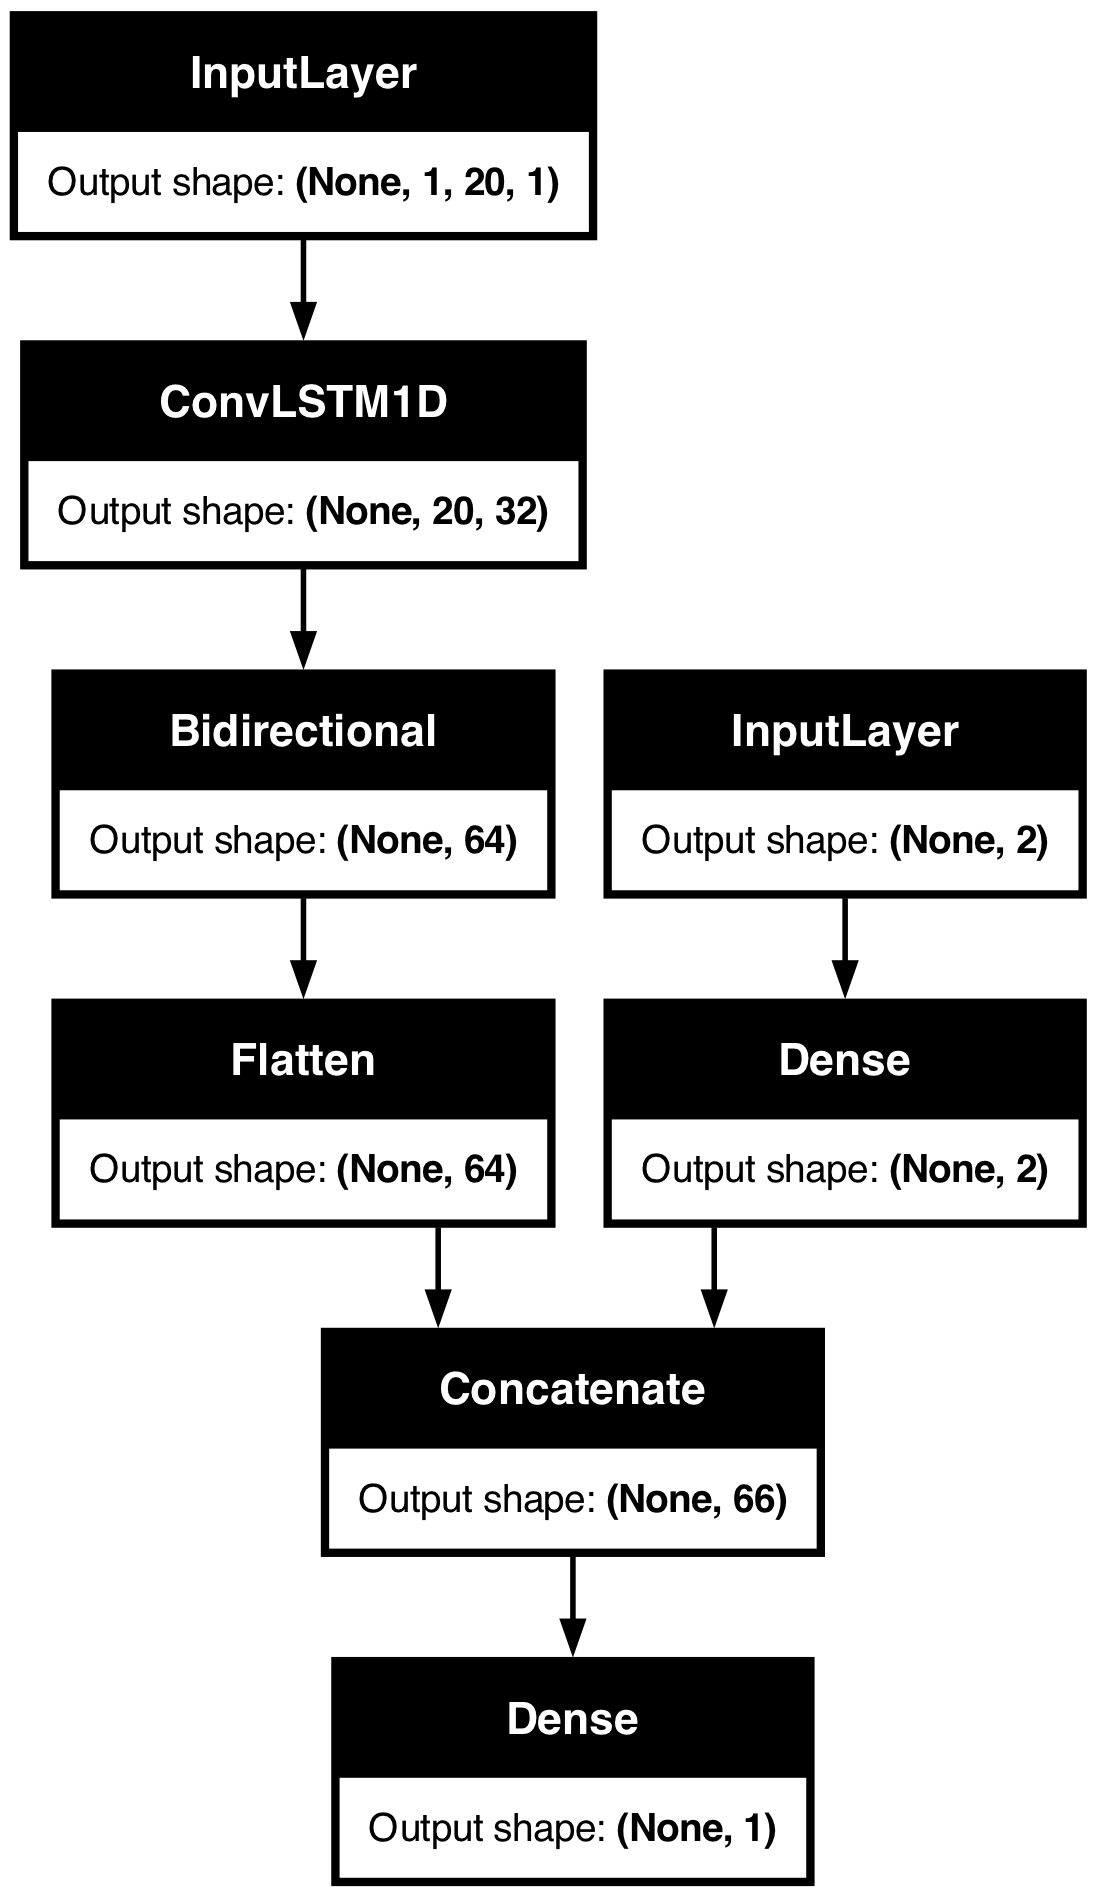

In [15]:
keras.utils.plot_model(cls_model, "cls_model.png", show_shapes=True)

In [16]:
cls_model.summary()

Model: "anomalous_detection"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 1, 20, 1)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm1d         │ (None, 20, 32)    │      8,576 │ signal[0][0]      │
│ (ConvLSTM1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     16,640 │ conv_lstm1d[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │          6 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 66)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         67 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,289 (98.79 KB)

 Trainable params: 25,289 (98.79 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cls_history = cls_model.fit(x=[train_input_signal, train_input_features],
                        y=train_label,
                        validation_data=([val_input_signal, val_input_features], val_label),
                        batch_size=BATCH_SIZE,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        callbacks=[early_stopping],
                        class_weight=class_weight,
                        verbose=2
                       )
cls_model.save('cls_model_.keras')

Epoch 1/10000


2024-05-09 19:58:44.869786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 - 5s - 5s/step - Acc: 0.6186 - JSC: 0.0085 - loss: 1.4549 - val_Acc: 0.6068 - val_JSC: 0.0000e+00 - val_loss: 0.7605
Epoch 2/10000
1/1 - 1s - 1s/step - Acc: 0.6176 - JSC: 0.0084 - loss: 1.4484 - val_Acc: 0.6068 - val_JSC: 0.0000e+00 - val_loss: 0.7586
Epoch 3/10000
1/1 - 1s - 1s/step - Acc: 0.6176 - JSC: 0.0084 - loss: 1.4419 - val_Acc: 0.6026 - val_JSC: 0.0000e+00 - val_loss: 0.7567
Epoch 4/10000
1/1 - 1s - 1s/step - Acc: 0.6176 - JSC: 0.0084 - loss: 1.4355 - val_Acc: 0.6026 - val_JSC: 0.0000e+00 - val_loss: 0.7549
Epoch 5/10000
1/1 - 1s - 1s/step - Acc: 0.6176 - JSC: 0.0084 - loss: 1.4290 - val_Acc: 0.6026 - val_JSC: 0.0000e+00 - val_loss: 0.7530
Epoch 6/10000
1/1 - 1s - 1s/step - Acc: 0.6176 - JSC: 0.0084 - loss: 1.4225 - val_Acc: 0.6026 - val_JSC: 0.0000e+00 - val_loss: 0.7512
Epoch 7/10000
1/1 - 1s - 1s/step - Acc: 0.6176 - JSC: 0.0084 - loss: 1.4159 - val_Acc: 0.6026 - val_JSC: 0.0000e+00 - val_loss: 0.7493
Epoch 8/10000
1/1 - 1s - 1s/step - Acc: 0.6176 - JSC: 0.0084 - loss: 

Epoch 63/10000
1/1 - 1s - 1s/step - Acc: 0.4778 - JSC: 0.2730 - loss: 1.0342 - val_Acc: 0.4487 - val_JSC: 0.2629 - val_loss: 0.7758
Epoch 64/10000
1/1 - 1s - 1s/step - Acc: 0.4778 - JSC: 0.2719 - loss: 1.0321 - val_Acc: 0.4487 - val_JSC: 0.2629 - val_loss: 0.7744
Epoch 65/10000
1/1 - 1s - 1s/step - Acc: 0.4789 - JSC: 0.2734 - loss: 1.0298 - val_Acc: 0.4530 - val_JSC: 0.2686 - val_loss: 0.7740
Epoch 66/10000
1/1 - 1s - 1s/step - Acc: 0.4789 - JSC: 0.2734 - loss: 1.0273 - val_Acc: 0.4530 - val_JSC: 0.2727 - val_loss: 0.7746
Epoch 67/10000
1/1 - 1s - 1s/step - Acc: 0.4789 - JSC: 0.2734 - loss: 1.0247 - val_Acc: 0.4573 - val_JSC: 0.2784 - val_loss: 0.7760
Epoch 68/10000
1/1 - 1s - 1s/step - Acc: 0.4745 - JSC: 0.2718 - loss: 1.0219 - val_Acc: 0.4573 - val_JSC: 0.2784 - val_loss: 0.7782
Epoch 69/10000
1/1 - 1s - 1s/step - Acc: 0.4745 - JSC: 0.2729 - loss: 1.0190 - val_Acc: 0.4573 - val_JSC: 0.2784 - val_loss: 0.7810
Epoch 70/10000
1/1 - 1s - 1s/step - Acc: 0.4735 - JSC: 0.2746 - loss: 1.0161

Epoch 125/10000
1/1 - 1s - 1s/step - Acc: 0.5439 - JSC: 0.3121 - loss: 0.8732 - val_Acc: 0.5299 - val_JSC: 0.2994 - val_loss: 0.7692
Epoch 126/10000
1/1 - 1s - 1s/step - Acc: 0.5460 - JSC: 0.3120 - loss: 0.8708 - val_Acc: 0.5299 - val_JSC: 0.2994 - val_loss: 0.7687
Epoch 127/10000
1/1 - 1s - 1s/step - Acc: 0.5471 - JSC: 0.3125 - loss: 0.8684 - val_Acc: 0.5342 - val_JSC: 0.3057 - val_loss: 0.7680
Epoch 128/10000
1/1 - 1s - 1s/step - Acc: 0.5482 - JSC: 0.3130 - loss: 0.8659 - val_Acc: 0.5342 - val_JSC: 0.3057 - val_loss: 0.7673
Epoch 129/10000
1/1 - 1s - 1s/step - Acc: 0.5482 - JSC: 0.3130 - loss: 0.8635 - val_Acc: 0.5385 - val_JSC: 0.3077 - val_loss: 0.7664
Epoch 130/10000
1/1 - 1s - 1s/step - Acc: 0.5482 - JSC: 0.3130 - loss: 0.8611 - val_Acc: 0.5385 - val_JSC: 0.3077 - val_loss: 0.7656
Epoch 131/10000
1/1 - 1s - 1s/step - Acc: 0.5482 - JSC: 0.3119 - loss: 0.8587 - val_Acc: 0.5342 - val_JSC: 0.3013 - val_loss: 0.7648
Epoch 132/10000
1/1 - 1s - 1s/step - Acc: 0.5515 - JSC: 0.3134 - loss